In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('Loan_Default_imputed.csv')

In [4]:
df.Status = df.Status.astype(int)

Weight of Evidence (WOE) And Information Value (IV) will be used to select features usefull for classification

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
bins = sc.woebin(df, y='Status')

[INFO] creating woe binning ...


C:\Users\Bartek\AppData\Roaming\Python\Python311\site-packages\scorecardpy\condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)
C:\Users\Bartek\AppData\Roaming\Python\Python311\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
C:\Users\Bartek\AppData\Roaming\Python\Python311\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future

Binning on 143942 rows and 31 columns in 00:00:28


In [6]:
df_woe = sc.woebin_ply(df, bins)

[INFO] converting into woe values ...
Woe transformating on 143942 rows and 30 columns in 00:00:15


In [7]:
iv_values = {col: bin_df['total_iv'].iloc[0] for col, bin_df in bins.items()}
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Variable', 'IV'])


In [8]:
iv_df.sort_values(by='IV', ascending=False)

,Variable,IV
7,credit_type,4.657177
2,rate_of_interest,0.619766
21,Interest_rate_spread,0.231496
22,income,0.154297
12,dtir1,0.141857
14,co-applicant_credit_type,0.110648
27,submission_of_application,0.084715
20,Neg_ammortization,0.083731
29,LTV,0.062206
10,loan_amount,0.040660


In [9]:
features=iv_df[iv_df['IV']>=0.03]['Variable'].to_list()

After calculating IV, we conclude that the features 'business_or_commercial', 'rate_of_interest', 'Gender', 'loan_type', 'income', 'Neg_ammortization', 'dtir1', 'credit_type', 'property_value','Interest_rate_spread', 'LTV', 'loan_amount', 'submission_of_application', 'co-applicant_credit_type', 'Upfront_charges' have sufficient predictive power (IV>=0.03) and would be used to train models.

In [10]:
features.append('Status')

In [11]:
df_learn = df[features]
df_learn.head()

,rate_of_interest,credit_type,Gender,loan_amount,dtir1,co-applicant_credit_type,property_value,Neg_ammortization,Interest_rate_spread,income,business_or_commercial,loan_type,submission_of_application,LTV,Status
0,4.199231,EXP,Sex Not Available,116500.0,45.000000,CIB,118000.000000,not_neg,0.522692,1740.0,nob/c,type1,to_inst,98.728814,1
1,3.940000,EQUI,Male,206500.0,43.615385,EXP,228769.230769,not_neg,1.006962,4980.0,b/c,type2,to_inst,87.282005,1
2,4.560000,EXP,Male,406500.0,46.000000,CIB,508000.000000,neg_amm,0.200000,9480.0,nob/c,type1,to_inst,80.019685,0
3,4.250000,EXP,Male,456500.0,42.000000,CIB,658000.000000,not_neg,0.681000,11880.0,nob/c,type1,not_inst,69.376900,0
4,4.000000,CRIF,Joint,696500.0,39.000000,EXP,758000.000000,not_neg,0.304200,10440.0,nob/c,type1,not_inst,91.886544,0


In [12]:
numerical_columns = df_learn.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = df_learn.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
sc = RobustScaler()
encoded = oh.fit_transform(df_learn[categorical_columns])
scaled = pd.DataFrame(sc.fit_transform(df_learn[numerical_columns]), columns = numerical_columns)
df_enc_scal = pd.concat([encoded, scaled], axis=1)

In [13]:
df_enc_scal.head()

,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,...,submission_of_application_not_inst,submission_of_application_to_inst,rate_of_interest,loan_amount,dtir1,property_value,Interest_rate_spread,income,LTV,Status
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.318501,-0.750000,0.545455,-0.882353,0.163920,-0.857143,0.984135,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,-0.076112,-0.375000,0.419580,-0.556561,0.906550,-0.155844,0.506653,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.867681,0.458333,0.636364,0.264706,-0.330931,0.818182,0.203719,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.395785,0.666667,0.272727,0.705882,0.406686,1.337662,-0.240224,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.015222,1.666667,0.000000,1.000000,-0.171139,1.025974,0.698722,0.0


In [14]:
X, y = df_enc_scal.drop('Status', axis=1), df_enc_scal.Status

# Logistic Regression

The GridSearchCV would be used for parameter tuning and cross validation.

In the first Logistic Regression model, our focus will be on achieving the highest possible overall score.

In [34]:
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic = GridSearchCV(logistic_model, param_grid_log, cv=5, n_jobs=-1)
grid_search_logistic.fit(X, y)

print("Best Parameters:", grid_search_logistic.best_params_)
print("Best Score:", grid_search_logistic.best_score_)

C:\Users\Bartek\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best Parameters: {'C': 0.0001, 'class_weight': None, 'penalty': None}
Best Score: 0.8571021596897829


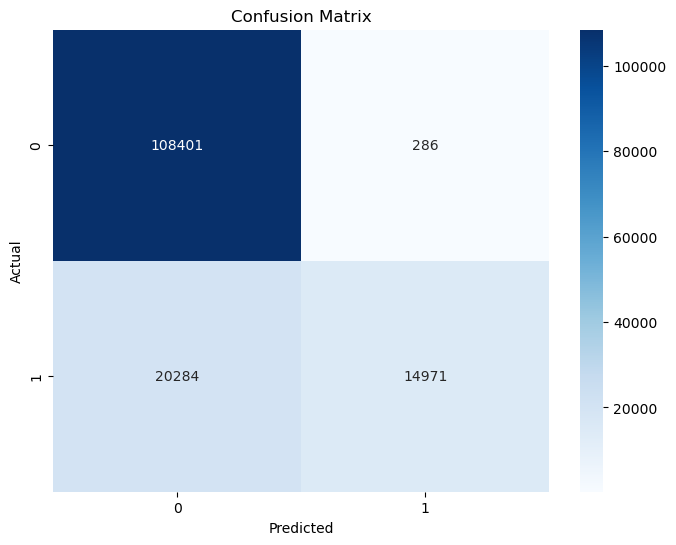

In [41]:
y_pred_log = grid_search_logistic.best_estimator_.predict(X)
cm_log = confusion_matrix(y,y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In the second Logistic Regression model, our primary objective will be to reduce False Negatives, which occur when loans are approved for individuals who ultimately default on repayment. By focusing on minimizing False Negatives, we aim to enhance the model's ability to accurately identify borrowers who may pose a higher risk of default. This strategic approach helps in mitigating financial losses for lenders.

In [36]:
logistic_model_rec = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log_rec = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic_rec = GridSearchCV(logistic_model_rec, param_grid_log_rec, cv=5, n_jobs=-1, scoring='recall')
grid_search_logistic_rec.fit(X, y)

print("Best Parameters:", grid_search_logistic_rec.best_params_)
print("Best Score:", grid_search_logistic_rec.best_score_)

Best Parameters: {'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Score: 0.6130194298681039


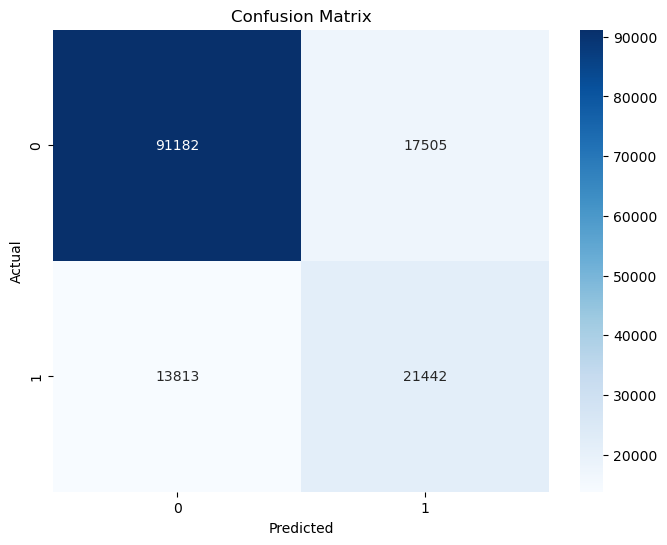

In [40]:
y_rec_pred = grid_search_logistic_rec.best_estimator_.predict(X)
cm_log_rec = confusion_matrix(y,y_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The overall accuracy of the second model is lower compared to the first model. However, we achieved a significant reduction in False Negatives and an increase in True Positives.

# SVM

In [ ]:
svm_model = SVC()

param_grid_svm = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'class_weight': [None, 'balanced']
}

grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm.fit(X, y)

print("Best Parameters:", grid_search_svm.best_params_)
print("Best Score:", grid_search_svm.best_score_)

In [ ]:
y_svm_pred = grid_search_svm.best_estimator_.predict(X)
cm_log_rec = confusion_matrix(y,y_svm_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()